In [1]:
# Step 1: Imports & Configuration

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# Visualization settings
plt.style.use("seaborn-v0_8")


In [2]:
# Step 2: Load Dataset

df = pd.read_csv("Loan_Data.csv")

In [3]:
# Basic info
print("Dataset Shape:", df.shape)
display(df.head())

# Data types & nulls
print("\nDataset Info:")
df.info()

# Target variable distribution
print("\nLoan Status Distribution:")
print(df['Loan_Status'].value_counts())

Dataset Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB

Loan Status Distribution:
Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [4]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
# Step 3: Data Cleaning

# Drop Loan_ID (not useful for prediction)
df.drop(columns=['Loan_ID'], inplace=True)

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include='number').columns

# Handle missing values
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Verify missing values
print("Missing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


STEP 4: Exploratory Data Analysis (EDA)

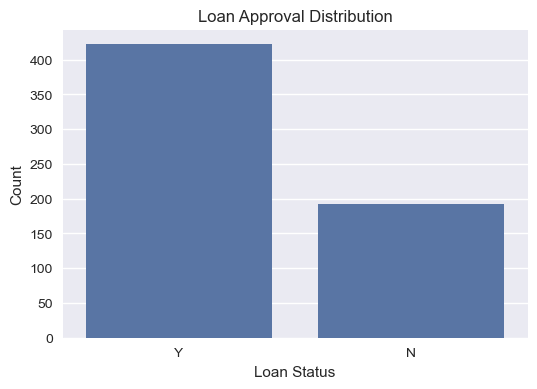

In [ ]:
# Target Variable Distribution

plt.figure(figsize=(6,4))
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()


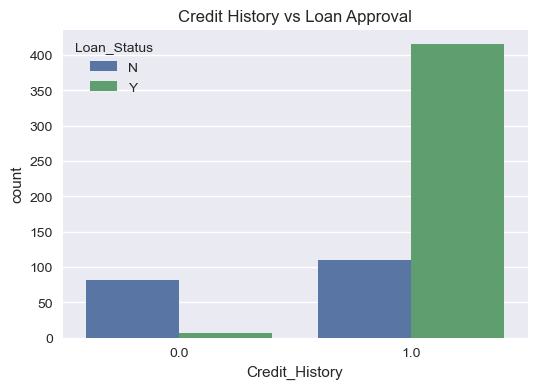

In [7]:
#Credit History vs Loan Status

plt.figure(figsize=(6,4))
sns.countplot(x='Credit_History', hue='Loan_Status', data=df)
plt.title("Credit History vs Loan Approval")
plt.show()


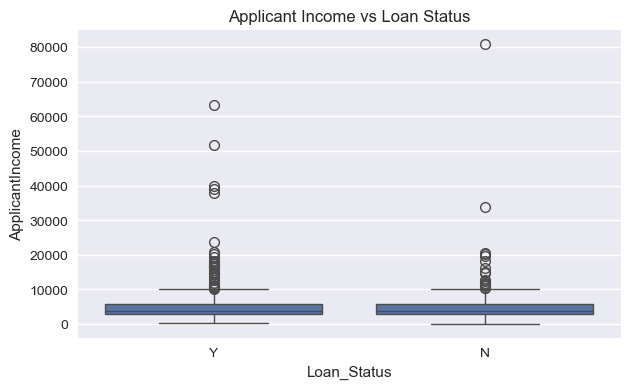

In [8]:
# Applicant Income vs Loan Status

plt.figure(figsize=(7,4))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df)
plt.title("Applicant Income vs Loan Status")
plt.show()


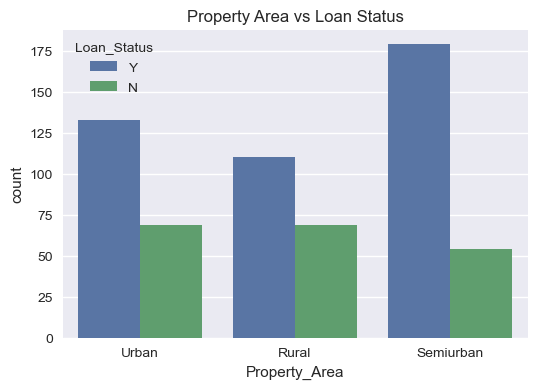

In [9]:
# Property Area Impact

plt.figure(figsize=(6,4))
sns.countplot(x='Property_Area', hue='Loan_Status', data=df)
plt.title("Property Area vs Loan Status")
plt.show()


EDA showed that credit history and applicant income have the strongest influence on loan approval, while property area also plays a moderate role. The dataset is imbalanced, which I addressed during modeling.

#### Step 5: Feature Encoding

In [10]:
# Encode target variable
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Label encode categorical features
label_encoders = {}

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Verify encoding
display(df.head())

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


Since SVM is a distance-based algorithm, I used label encoding to convert categorical features into numeric form while maintaining computational efficiency.

#### Step 6: Train-Test Split


In [11]:
# Step 6: Train-Test Split

X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verify class distribution
print("Train set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))


Train set distribution:
Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Test set distribution:
Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


I used stratified sampling to preserve the original class distribution and avoid biased evaluation.

In [ ]:
# Step 7: Build Pipeline (Scaler + SVM)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='linear',
        class_weight='balanced',   # handles class imbalance
        random_state=42
    ))
])

# Train the model
pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'


In [13]:
# Step 8: Hyperparameter Tuning

param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',   # better than accuracy for imbalance
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)


Best Parameters: {'svm__C': 0.01}
Best CV F1 Score: 0.8699456484348126


I tuned the SVM regularization parameter using GridSearchCV with F1-score to handle class imbalance and improve generalization.

#### Model Evaluation (Best SVM)

In [14]:
# Step 9.1: Predictions

y_pred = best_model.predict(X_test)


In [15]:
# Step 9.2: Evaluation Metrics

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8536585365853658
Precision: 0.8316831683168316
Recall: 0.9882352941176471
F1 Score: 0.9032258064516129

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



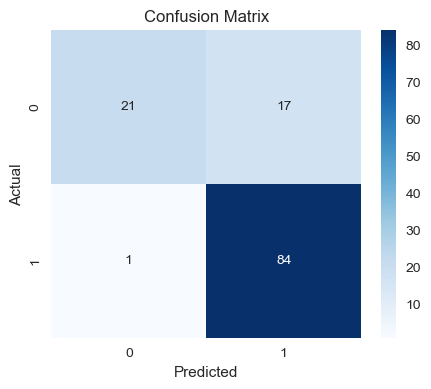

In [16]:
# Step 9.3: Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


The model prioritizes minimizing false negatives, ensuring that eligible loan applicants are rarely rejected. Although there are some false positives, this trade-off is acceptable in real-world loan approval systems to improve customer satisfaction.

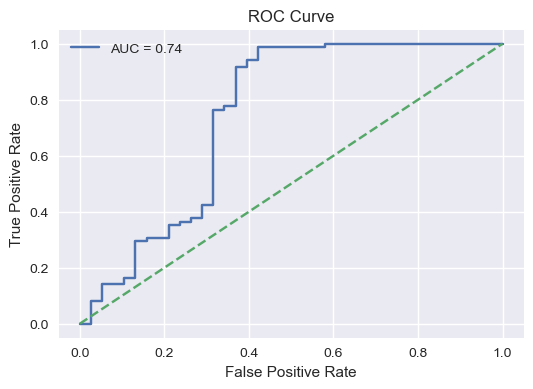

In [17]:
# Step 9.4: ROC Curve

y_scores = best_model.decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_scores)

fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [18]:
# Step 10: Save Final Model

joblib.dump(best_model, "svm_loan_approval_pipeline.pkl")

print("Model saved successfully!")


Model saved successfully!
